# **Introductions**

In this notebook, we aim to identify the features that truly matter when it comes to eviction risks, focusing on how SVI, building characteristics, and tenant complaint behavior contribute — both independently and interactively — to eviction severity. (Currently, the analysis covers only SVI and building features, using the fully cleaned and merged dataset.)

From previous analysis, we’ve already seen that (multi)linearity cannot fully capture the overall relationships/nuances between input features and eviction rates. In this notebook, we demonstrate how and why non-linear (tree-based) models can better explain these relationships and help us uncover the most influential features and how they affect eviction outcomes.

We selected DT and Random Forests for their ability to capture non-linear relationships, discover natural feature thresholds/slits, and generate interpretable outputs (as opposed to black-box models that emphasize more than predicted values) such as feature importances and partial dependence plots. We chose these models to support our goal of understanding structural eviction risk and identifying actionable intervention plans, rather than purely maximizing predictive accuracy.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times.csv"

In [ ]:
df_raw = pd.read_csv(file_path)

In [ ]:
df = df_raw.copy()

In [ ]:
df.columns

Index(['primary_key', 'bbl', 'court_index_number', 'docket_number',
       'eviction_address', 'eviction_apartment_number', 'executed_date',
       'borough', 'zipcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'nta', 'year', 'month_year', 'geometry',
       'average_year_eviction_count', 'yearbuilt', 'bldgclass', 'numfloors',
       'unitsres', 'ownername', 'bldgarea', 'building_type',
       'building_category', 'is_condo', 'floor_category', 'rent_era',
       'architectural_style', 'economic_period', 'residential_units_category',
       'is_llc', 'building_size_category', 'size_quartile', 'decade', 'fips',
       'e_totpop', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4',
       'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
       'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh',
       'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian',

# **Part 1: If there is no strong linear relationships between SVI data and the eviction rate, what non-linear relationships could these svi measurements have with the eviction rate (per year, per building)?**

**Part 1.1 Spearsman rank correlation: good for detecting and measuring monotonic relationships even if not linear nor normally distributed.**

In [ ]:
df_svi = df.copy()

In [ ]:
svi_vars = ['rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4', 'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
  'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh', 'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian', 'ep_aian',
  'ep_nhpi', 'ep_twomore', 'ep_otherrace', 'ep_minrty', 'ep_white', 'svi_quartile']

In [ ]:
df_svi.svi_quartile.unique()
# these are strings, and will not work with the analysis.

array(['Q3', 'Q4 (High)', 'Q2', 'Q1 (Low)'], dtype=object)

In [ ]:
df_svi.svi_quartile = df_svi.svi_quartile.str.extract(r'Q(\d)').astype(int)

In [ ]:
df_svi.svi_quartile.unique(), df_svi.svi_quartile[0].dtype

(array([3, 4, 2, 1]), dtype('int64'))

In [ ]:
check_nan = df_svi[['average_year_eviction_count'] + svi_vars].isna().sum()
check_nan
# just in case, check nans

,0
average_year_eviction_count,0
rpl_theme1,0
rpl_theme2,0
rpl_theme3,0
rpl_theme4,0
rpl_themes,0
ep_pov150,0
ep_unemp,0
ep_nohsdp,0
ep_uninsur,0


In [ ]:
df_spearman = df_svi[['average_year_eviction_count'] + svi_vars]
# corret way to combine columns, saving space

In [ ]:
corr_matrix = df_spearman.corr(method='spearman')

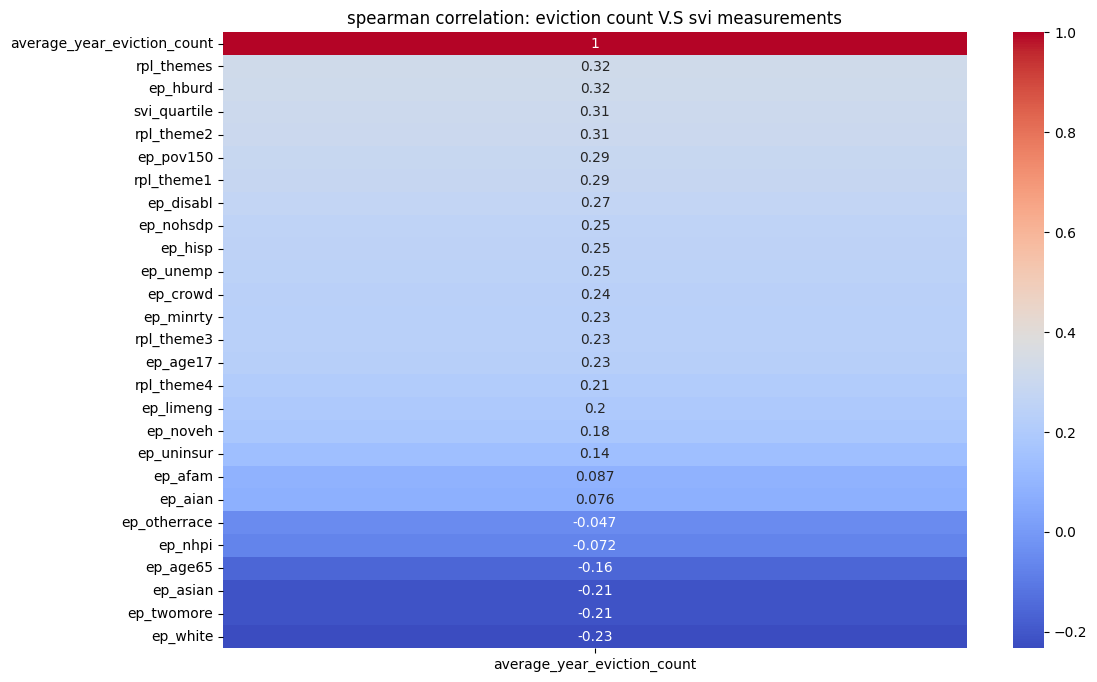

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['average_year_eviction_count']].sort_values(by='average_year_eviction_count', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count V.S svi measurements')
plt.show()

**What this chart is showing:**

**The SVI measurements showing the strongest positive correlations with eviction counts are:**

rpl_themes (0.32): overall themes of social vulnerability \
ep_hburd (0.32): housing burden \
svi_quatile (0.31): the quartile svi falls into \
rpl_theme2 (0.31): household composition and disability \
ep_pov150 (0.29): poverty measures \
rpl_theme1 (0.29): low income measures \

**moderate positive correlations (0.23-0.27) exist with:** \

ep_disabl: disability \
ep_nohsdp: no high school diploma \
ep_hisp: hispanic population \
ep_unemp: unemployment \
ep_crowd: crowded housing \
ep_minrty: minority populations \

**strongest negative correlations are shown with:**

ep_white (-0.23): white population percentage
ep_twomore (-0.21): two or more races
ep_asian (-0.21): Asian population
ep_age65 (-0.16): population over 65

**what this suggests:**

1. Evictions are more frequent in areas with higher **social vulnerability housing burden** and **household composition factors** have the strongest relationship with evictions
2. areas with higher percentages of white and Asian populations tend to have fewer evictions
3. areas with older populations (65+) have slightly fewer evictions

**Part 1.2 Mutural information scores: measuring non-linear dependencies between features, and is good for discovering how much information one variable gives about another.**

In [ ]:
df_svi.isna().sum().sum()
# just double checking

np.int64(0)

In [ ]:
X = df_svi[svi_vars]
y = df_svi['average_year_eviction_count']

mi_scores = mutual_info_regression(X, y)

In [ ]:
mi_df = pd.DataFrame({'svi_measurements': svi_vars, 'mi_scores': mi_scores})
mi_df = mi_df.sort_values(by='mi_scores', ascending=False)

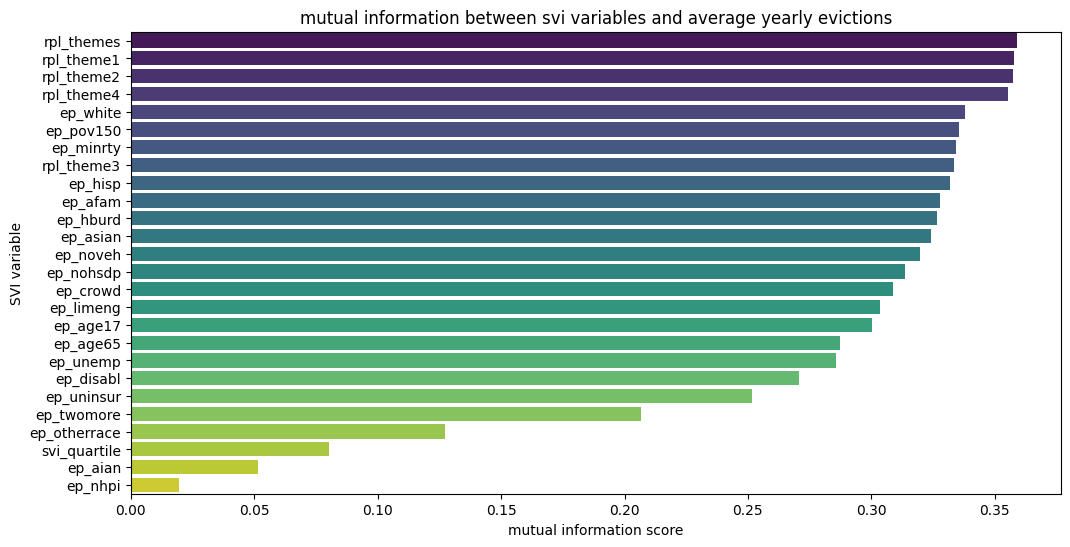

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=mi_df, x='mi_scores', y='svi_measurements', palette='viridis')
plt.title("mutual information between svi variables and average yearly evictions")
plt.xlabel("mutual information score")
plt.ylabel("SVI variable")
plt.show()

**Interestingly, the white population seems be have a larger mutual information scores than what we have learned from linear model. Some ofther key insight from this graph is that the composite theme scores, especially those related to socioeconomic status, housing, and transportation, are the most informative predictors of eviction counts, while specific racial/ethnic categories (particularly those with smaller population percentages) provide less information overall**

In [ ]:
X_svi = df[svi_vars]

In [ ]:
svi_quartile_map = {
    'Q1 (Low)': 1,
    'Q2': 2,
    'Q3': 3,
    'Q4 (High)': 4
}
X_svi['svi_quartile_num'] = X_svi['svi_quartile'].map(svi_quartile_map)

In [ ]:
X_svi.svi_quartile_num.unique()

array([3, 4, 2, 1])

In [ ]:
X_svi.drop('svi_quartile', axis=1, inplace=True)

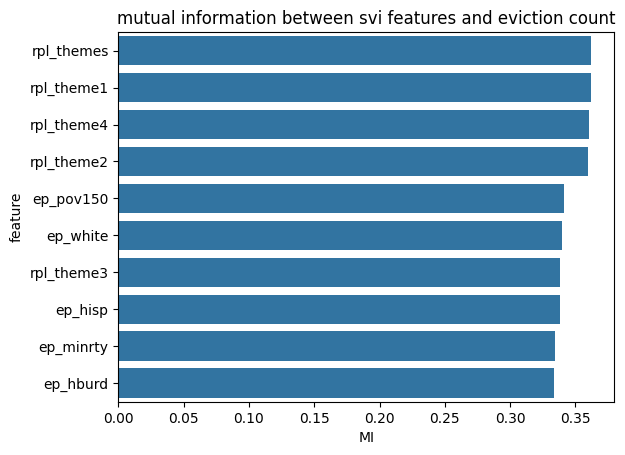

In [ ]:
mi_scores = mutual_info_regression(X_svi, df_svi['average_year_eviction_count'])

mi_df = pd.DataFrame({'feature': X_svi.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False)
sns.barplot(data=mi_df.head(10), x='MI', y='feature')
plt.title("mutual information between svi features and eviction count")
plt.show()
# we will go into details after we run random forest regressor below

In [ ]:
# y = df['average_year_eviction_count']
# X_svi = df_svi[svi_vars].copy()
# X_train_svi, X_test_svi, y_train, y_test = train_test_split(X_svi, y, test_size=0.2, random_state=42)
# model_svi = RandomForestRegressor(n_estimators=100, random_state=42)
# model_svi.fit(X_train_svi, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# # top 6
# top_svi_features = ['rpl_themes', 'rpl_theme1', 'rpl_theme4', 'rpl_theme2', 'ep_pov150', 'ep_white']

# PartialDependenceDisplay.from_estimator(
#     model_svi,
#     X_svi,
#     top_svi_features,
#     kind='average',
#     # pdp
#     grid_resolution=100
# )
# plt.suptitle("partial dependence of top SVI 6 features on eviction count", fontsize=14)
# plt.tight_layout()
# plt.show()
# # ep_pov150: percentage of people below 150% of the federal poverty line
# # see after we ran rfr, and we will get the 10 factors below

In [ ]:
# PartialDependenceDisplay.from_estimator(
#     model_svi,
#     X_svi,
#     ['ep_pov150'],
#     kind='both',
#     grid_resolution=100
# )
# plt.title("PDP + ICE for poverty level (ep_pov150)")
# plt.tight_layout()
# plt.show()
# # will see later.

**Part 1.3 we will use a decision tree regressor to rank SVI variables by how much they reduce impurity in predicting eviction counts (again, in general, they work well for non-linear relationships, and we aim to find a few features that may be different from what linear regression told us.).**

results are not as good/clear as we thought. It may not be good for this analysis as DT usually is sensitive to noisy data and variances, which is the case for eviction rates and many features. Currently, we will not go into this graph, as the most telling one at this moment should be RandomForest and PDP results, because we want to to know how each feature actually affect the eviction rates.

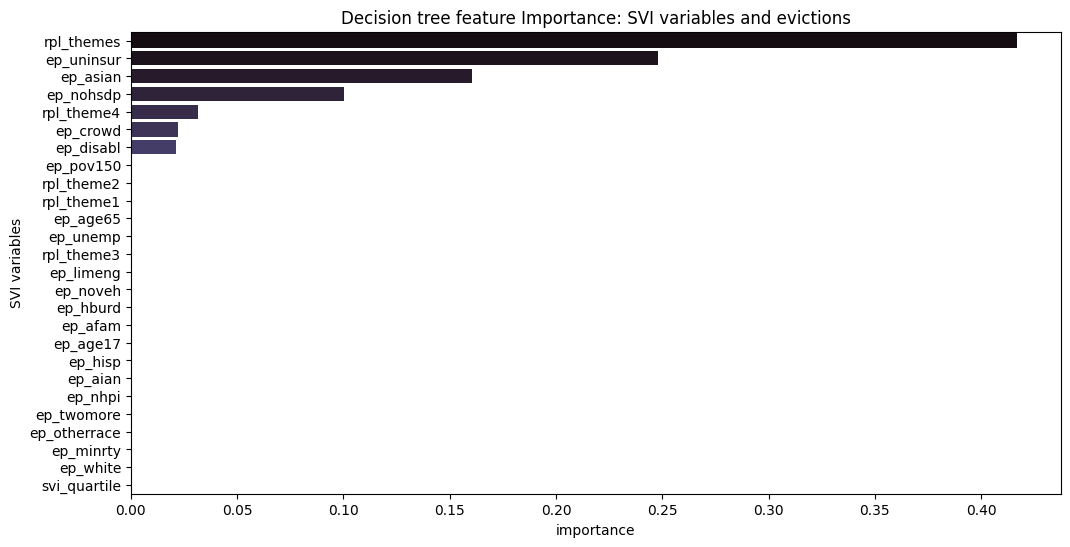

In [ ]:
tree_model = DecisionTreeRegressor(max_depth=4)
tree_model.fit(X, y)
importances = tree_model.feature_importances_

imp_df = pd.DataFrame({'SVI variables': svi_vars, 'importance': importances})
imp_df = imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=imp_df, x='importance', y='SVI variables', palette='mako')
plt.title("Decision tree feature Importance: SVI variables and evictions")
plt.show()


**Part 1.4 RandomForestRegressor analysis + PDP**

In [ ]:
X = df_svi[svi_vars]
y = df_svi['average_year_eviction_count']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)
df_svi['predicted_eviction_count'] = model.predict(X)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"mse {mse:.2f}, r square {r2:.2f}")
# not so good predictive value for building features and eviction rates.

mse 4.45, r square 0.08


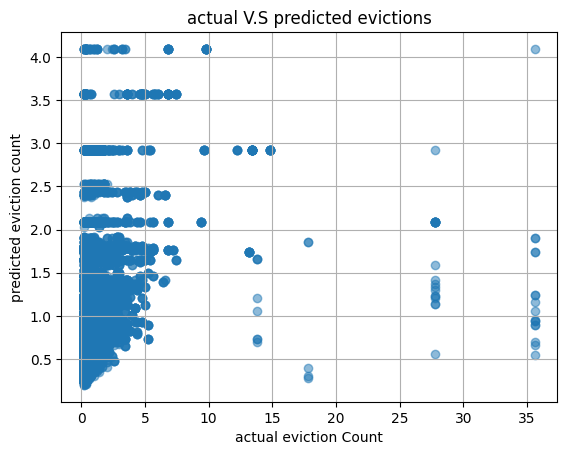

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("actual eviction Count")
plt.ylabel("predicted eviction count")
plt.title("actual V.S predicted evictions")
plt.grid(True)
plt.show()

**This shows the random forest regressor does not perform very well in predicting eviction counts with the svi data. Not surprised, given the complex social dynamics behind evictions, which likely extend beyond the SVI. However, RFR still can capture how each factor contributes to the eviction rate in their own ways (non-linear).**

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

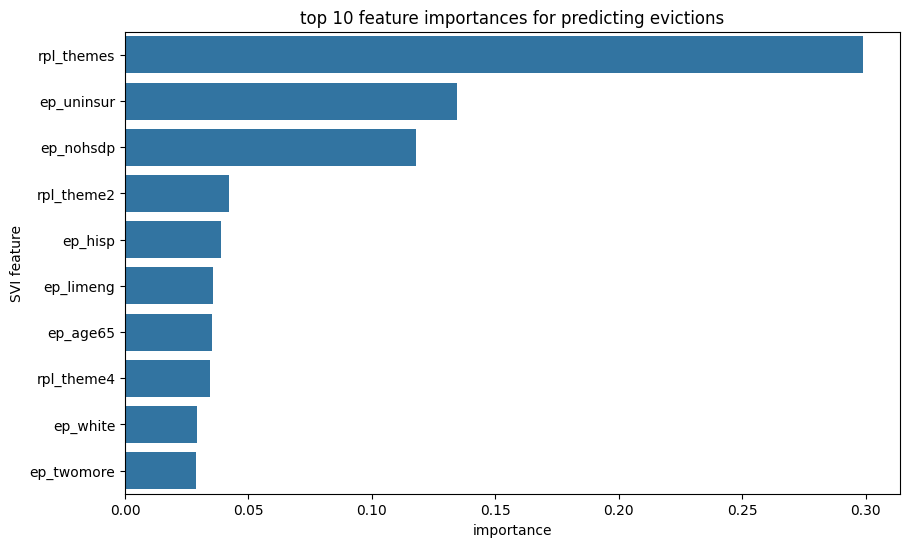

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values[:10], y=feat_importances.index[:10])
plt.title("top 10 feature importances for predicting evictions")
plt.xlabel("importance")
plt.ylabel("SVI feature")
plt.show()

In [ ]:
top_features_idx = np.argsort(model.feature_importances_)[-10:]
top_features = [svi_vars[i] for i in top_features_idx]

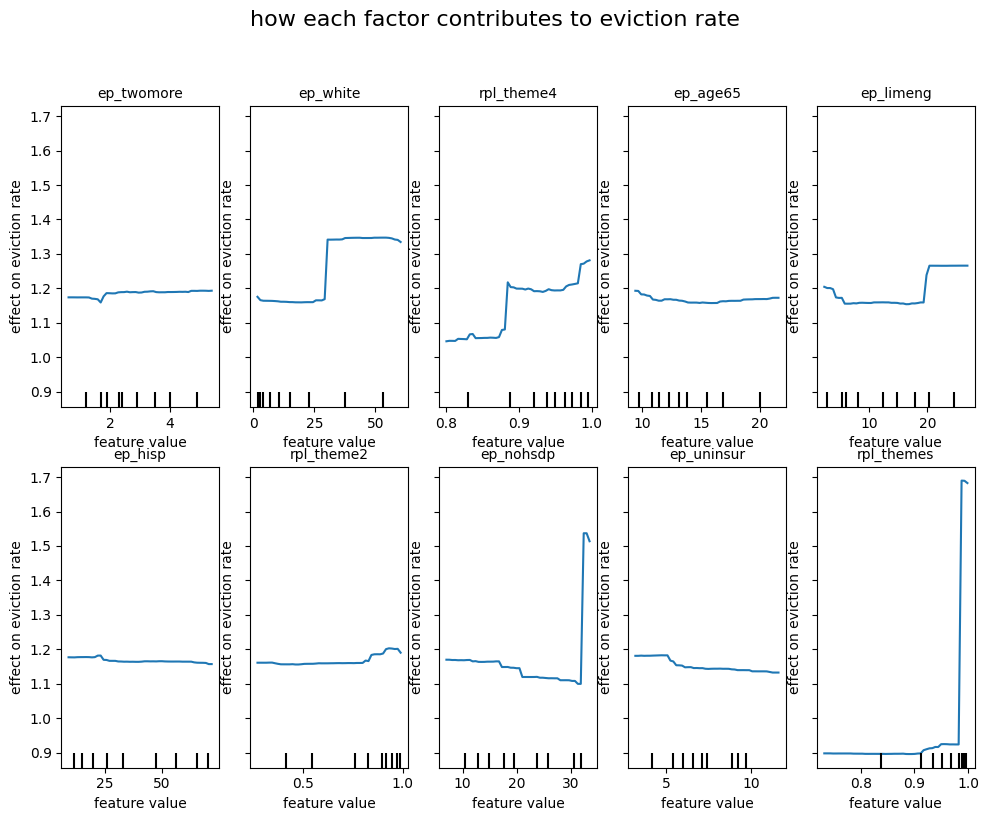

In [ ]:
display = PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

- ep_twomore (households with 2+ units sharing housing):
Generally has a positive effect, slightly above 1.2. More such households ---> higher eviction rate.
- ep_white (proportion of white population):
nonlinear jump: At around 20–25%, a sharp increase in eviction rate effect is observed. areas with a sudden increase in White population may experience higher predicted eviction rates.
- rpl_theme4 (a theme in the Social Vulnerability Index):
gradual increase in eviction rate with higher scores, especially after ~0.9. It suggests vulnerability theme 4 has a compounding negative effect.
- ep_age65 (percent of population 65+):
negative correlation: more elderly population tends to reduce predicted eviction rate slightly.
- ep_limeng (limited english proficiency):
noticeable jump near value 20 leads to sharp increase in predicted eviction. linguistic barriers might correlate with housing instability.
- ep_hisp (percent hispanic):
Slight upward trend ---> modest increase in eviction rate with increasing Hispanic population proportion.
- rpl_theme2 (another vulnerability theme):
Fairly flat, small rise past 0.9, but not very strong overall influence.
- ep_nohsdp (percent without high school diploma):
Effect increases gradually, then jumps after ~30. Strong correlation: lower education attainment ---> higher eviction risk.
- ep_uninsur (uninsured population):
mostly flat or slightly negative: may not significantly affect eviction in the model.
- rpl_themes (overall vulnerability index):
Sharp spike after 0.95. It suggests very high social vulnerability leads to a steep increase in eviction risk.

In [ ]:
df_building = df.copy()

In [ ]:
df_building.floor_category.unique()

array(['low-rise', 'mid-rise', 'high-rise'], dtype=object)

# **Part 2: Check linearity and Tree-based nonlinear models with eviction rates and building features**

## **Part 2.1 Spearsman rank correlation: good for detecting and measuring monotonic relationships even if not linear nor normally distributed.**

In [ ]:
building_vars = ['yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea', 'building_type', 'building_category', 'is_condo',
'floor_category', 'rent_era', 'architectural_style', 'residential_units_category', 'is_llc', 'building_size_category',
'size_quartile', 'decade',]

### **Since many of these columns are strings, not numeric, we will convert them to numerics based on their properties. We will examine these features case by case.**

1. These categories can be removed: because they have had original columns that had numeric datatypes and was abstrcted to be categorical ones: decade, rent_era, economic_period. \

2. These columns do not make much sense to be used for regression analysis: ownername.

3. Binary-encoding: is_condo, is_llc.

4. Ordinal encodings: floor_category, residential_units_category, building_size_category, size_quartile,

5. Nominal categories: building_type, architectural_style [because they do not have natural orders; in this case, we will use one-hot encoding].

6. Nominal categories (label encoding, because we just need arbitrary labels):  bldgclass [actually, this was done already by nature, but we will re-label them so they do not seem too arbitrary.]

7. Temporal-based --> make them into ages: yearbuilt ->  20 (years old).

In [ ]:
df_building.architectural_style.unique()

array(['1921–1930, Art Deco Skyscrapers', '1900–1920, Beaux-Arts',
       '1951–1980, the International Style, Alternative Modernism',
       '1931–1950, Manhattan Modern', '1981–2000, Post-Modernism',
       '2001-present, New Architecture', 'Pre-1900'], dtype=object)

In [ ]:
df_building.size_quartile[0]

'Q3 (50-75%)'

In [ ]:
floats = ['yearbuilt', 'numfloors', 'unitsres', 'bldgarea']
df_building.yearbuilt[0].dtype, df_building.numfloors[0].dtype, df_building.unitsres[0].dtype, df_building.bldgarea[0].dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [ ]:
# other columns' types
type(df_building.building_type[0]), type(df_building.architectural_style[0]), type(df_building.bldgclass[0]), type(df_building.building_category[0]), type(df_building.is_condo[0]), \
type(df_building.is_llc[0]), type(df_building.residential_units_category[0]), type(df_building.building_size_category[0]), type(df_building.size_quartile[0]), type(df_building.decade[0])

(str, str, str, str, numpy.bool, numpy.bool, str, str, str, str)

In [ ]:
df_building.building_type[0], df_building.building_category[0]
# different types of categorizations, just to make sure

('pre-war', 'walk-up')

In [ ]:
df_building.residential_units_category.unique()

array(['3-5 units', '2-unit', '100+ units', '21-100 units', 'single-unit',
       '6-20 units'], dtype=object)

In [ ]:
# let's do binary encoding first
binary_vars = ['is_condo', 'is_llc']
for var in binary_vars:
  if var in df.columns:
    df_building[var] = df_building[var].astype(int)

In [ ]:
# ordinal encoding, choose the mid-points of those ranges
# to reserve
residential_unit_mapping = {
    'single-unit': 1,
    '2-unit': 2,
    '3-5 units': 4,
    '6-20 units': 13,
    '21-100 units': 60,
    '100+ units': 150
}

In [ ]:
df_building['residential_units_category'] = df_building['residential_units_category'].map(residential_unit_mapping)

In [ ]:
# df[df['residential_units_category'] >= 100]
df_building.floor_category.unique(), df_building.building_size_category.unique(), df_building.size_quartile.unique()

(array(['low-rise', 'mid-rise', 'high-rise'], dtype=object),
 array(['small', 'very small', 'medium-small', 'mega', 'very large',
        'large', 'medium', 'tiny'], dtype=object),
 array(['Q3 (50-75%)', 'Q1 (smallest 25%)', 'Q4 (largest 25%)',
        'Q2 (25-50%)'], dtype=object))

In [ ]:
size_mapping = {
    'tiny': 1,
    'very small': 2,
    'small': 3,
    'medium-small': 4,
    'medium': 5,
    'large': 6,
    'very large': 7,
    'mega': 8
}

In [ ]:
df_building['building_size_category'] = df_building['building_size_category'].map(size_mapping)

In [ ]:
floor_category_mapping = {'low-rise': 1, 'mid-rise': 2, 'high-rise': 3}
df_building['floor_category'] = df_building['floor_category'].map(floor_category_mapping)

In [ ]:
size_quartile_mapping = {'Q1 (smallest 25%)': 1, 'Q2 (25-50%)': 2, 'Q3 (50-75%)': 3, 'Q4 (largest 25%)': 4}
df_building['size_quartile'] = df_building['size_quartile'].map(size_quartile_mapping)

In [ ]:
df_building.building_type.nunique(), df_building.architectural_style.nunique(), df_building.bldgclass.nunique()

(2, 7, 48)

In [ ]:
df_building.bldgclass.unique()
# these actually do not have any meanings after all, was used to make sure they are al residential buildings
# here, they are all residential buildings, some as aparments, conods, and some as mixed....
# so we will not do anything to this column name

array(['C0', 'B2', 'C3', 'D4', 'D7', 'D1', 'C1', 'C2', 'D3', 'A5', 'R1',
       'A1', 'B1', 'D9', 'D6', 'S2', 'C7', 'R4', 'C4', 'D5', 'R2', 'C6',
       'B3', 'A2', 'C9', 'R3', 'S4', 'S3', 'B9', 'C5', 'S9', 'S5', 'D2',
       'D8', 'A9', 'S1', 'A4', 'RR', 'A8', 'A0', 'A6', 'R9', 'D0', 'R5',
       'S0', 'A7', 'A3', 'C8'], dtype=object)

In [ ]:
# since building type only has 2 types, we will just
# convert 'pre-war' --> 0, 'post-war' --> while keeping column name
# also binary enconding
df_building['building_type'] = (df_building['building_type'] == 'post-war').astype(int)

In [ ]:
df_building['building_age'] = pd.Timestamp.now().year - df_building['yearbuilt']

In [ ]:
# architectural style naturally and certainly is good for label encoding,
# but for regression, we will use 1-7, aka ordinal encoding
# to avoid bias, we will use frequency encoding,
# we will add new columns to account for these three different types of encoding to
# avoid confusion and only use the good columns whenever necessary
era_order = {
    'Pre-1900': 1,
    '1900–1920, Beaux-Arts': 2,
    '1921–1930, Art Deco Skyscrapers': 3,
    '1931–1950, Manhattan Modern': 4,
    '1951–1980, the International Style, Alternative Modernism': 5,
    '1981–2000, Post-Modernism': 6,
    '2001-present, New Architecture': 7
}

In [ ]:
df_building['style_ordinal'] = df_building['architectural_style'].map(era_order)

In [ ]:
# frequence encoding
style_freq = df_building['architectural_style'].value_counts(normalize=True)
df_building['style_freq'] = df_building['architectural_style'].map(style_freq)

In [ ]:
# label encoding
df_building['style_label'] = LabelEncoder().fit_transform(df['architectural_style'])

In [ ]:
# df_building.columns

In [ ]:
# for building category, we will also use these all three types of encoding and only use them whenever necessary
df_building.building_category.unique()

array(['walk-up', 'two-family', 'condo-co-op', 'elevator',
       'single-family', 'primarily_res_with_mixed_use'], dtype=object)

In [ ]:
ordinal_mapping = {
    'single-family': 1,
    'two-family': 2,
    'walk-up': 3,
    'primarily_res_with_mixed_use': 4,
    'condo-co-op': 5,
    'elevator': 6
}
# only good for regression

In [ ]:
df_building['building_category_ordinal'] = df_building['building_category'].map(ordinal_mapping)

In [ ]:
# using frequency encoding
freq = df_building['building_category'].value_counts(normalize=True)
df_building['building_category_freq'] = df_building['building_category'].map(freq)
# to have the most diverse set of values assigned to them to avoid bias

In [ ]:
# freq = df['building_category'].value_counts(normalize=True)

In [ ]:
df_building['building_category_le'] = LabelEncoder().fit_transform(df_building['building_category'])
# label encoding: good for random forest or XGBoost

In [ ]:
new_building_vars = ['numfloors', 'building_category_ordinal', 'unitsres', 'bldgarea', 'building_type', 'is_condo', 'is_llc',
  'style_ordinal', 'building_age', 'floor_category', 'size_quartile', 'building_size_category', 'residential_units_category']

In [ ]:
df_building[new_building_vars].head()
# all numeric columns, except the frequency counts and the label encoding ones, as they are not suitable for linear
# regression anyways. Will be utilized in other places later.

,numfloors,building_category_ordinal,unitsres,bldgarea,building_type,is_condo,is_llc,style_ordinal,building_age,floor_category,size_quartile,building_size_category,residential_units_category
0,3.0,3,3.0,2700.0,0,0,1,3,95.0,1,3,3,4
1,2.0,2,2.0,1204.0,0,0,1,2,105.0,1,1,2,2
2,4.0,3,4.0,4800.0,0,0,0,2,118.0,2,4,4,4
3,21.0,5,352.0,381213.0,1,1,0,5,58.0,3,4,8,150
4,6.0,6,65.0,69102.0,0,0,1,3,97.0,2,4,7,60


In [ ]:
check_nan = df_building[['average_year_eviction_count'] + new_building_vars].isna().sum()
check_nan
# just in case, check nans

,0
average_year_eviction_count,0
numfloors,0
building_category_ordinal,0
unitsres,0
bldgarea,0
building_type,0
is_condo,0
is_llc,0
style_ordinal,0
building_age,0


In [ ]:
target_and_features = ['average_year_eviction_count'] + new_building_vars
df_spearman = df_building[target_and_features].copy()

In [ ]:
spearman_corr = df_spearman.corr(method='spearman')['average_year_eviction_count'].sort_values(ascending=False)
spearman_corr

,average_year_eviction_count
average_year_eviction_count,1.000000
unitsres,0.569820
bldgarea,0.563387
building_size_category,0.559404
residential_units_category,0.546332
numfloors,0.530388
floor_category,0.497768
building_category_ordinal,0.452105
size_quartile,0.336429
style_ordinal,0.221469


In [ ]:
# df_spearman = df_building['average_year_eviction_count'] + df_building[new_building_vars]
# # this line would use up ram very quickly,because this is creating unnecessary intermediate DataFrames when concatenating columns
# # not the correct way to combine columns (it tries to add values instead of merging columns).

In [ ]:
# df[new_building_vars].head()
# # all numeric values

In [ ]:
corr_matrix = df_spearman.corr(method='spearman')

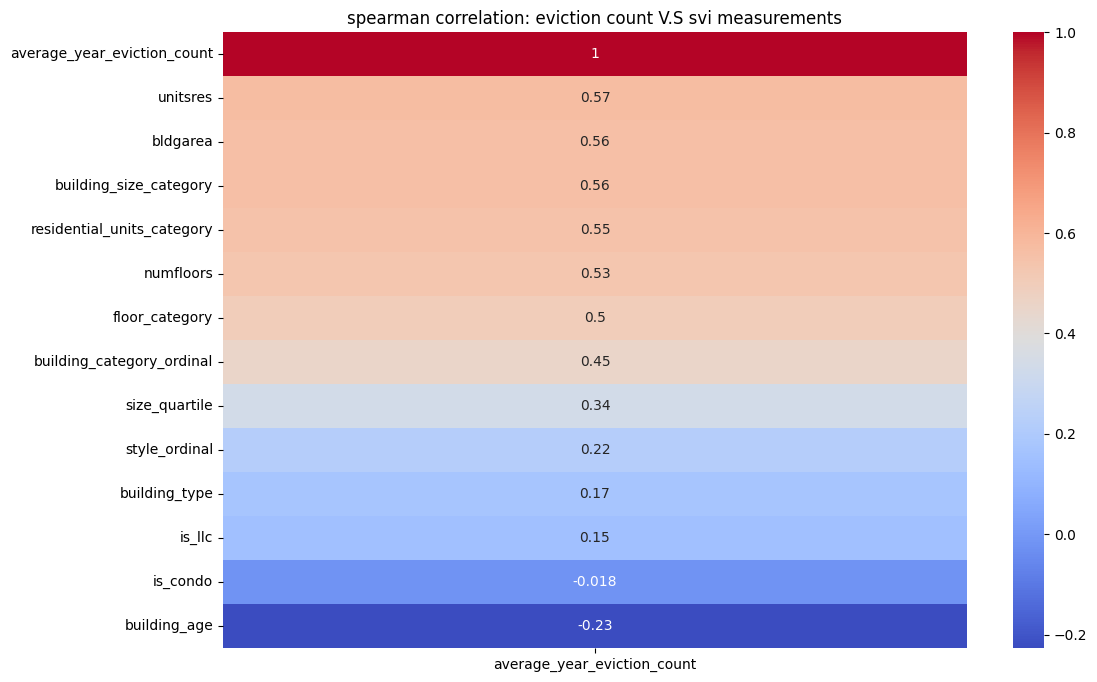

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['average_year_eviction_count']].sort_values(by='average_year_eviction_count', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count V.S svi measurements')
plt.show()
# important
# very good scores

**strong positive correlations (0.5 and above)**
These factors are most associated with higher eviction rates:
unitsres (0.57): More residential units -->  higher evictions. \
bldgarea (0.56): Larger building area --> higher evictions. \
building_size_category (0.56): Bigger buildings --> higher evictions. \
residential_units_category (0.55): More units --> Higher evictions. \
numfloors (0.53): Taller buildings --> Higher evictions. \

**Short summaries**:

Nohing really suprising here, as previously known, we need to focus on large, multi-unit residential buildings for eviction prevention programs.

**moderate Positive Correlations (0.3–0.5)**
floor_category (0.5): Higher floors --> slightly more evictions. \
building_category_ordinal (0.45): certain building types (e.g., elevators) --> more evictions. \
size_quartile (0.34): Larger size quartiles --> mildly higher evictions. \

note: some of these columns actually point to the same thing, since there was no large discrepency here, it is fairly reasonable to say larger, taller buildings have more evictions.  \

**However, this is just the linear regression analysis. What if there are fatcors not captured by this test?**

**Part 2.2 Tree-based model: we use mutural information scores (mis): measuring non-linear dependencies between features, and is good for discovering how much information one variable gives about another.**

In [ ]:
X = df_building[new_building_vars].fillna(0)
y = df_building['average_year_eviction_count'].fillna(0)

mi_scores = mutual_info_regression(X, y)

In [ ]:
mi_df = pd.DataFrame({'building_measurements': new_building_vars, 'mi_scores': mi_scores})
mi_df = mi_df.sort_values(by='mi_scores', ascending=False)

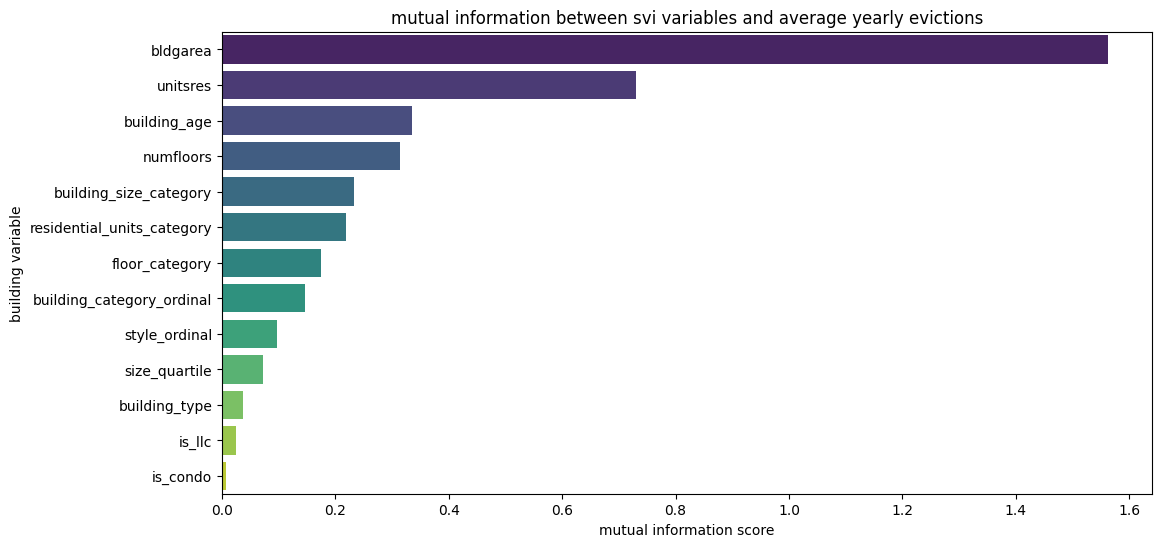

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=mi_df, x='mi_scores', y='building_measurements', palette='viridis')
plt.title("mutual information between svi variables and average yearly evictions")
plt.xlabel("mutual information score")
plt.ylabel("building variable")
plt.show()

**Interestingly, 'building age' comes to the picture, and turns out to be a very good factor predicting the evictions. This is a feature that was not captured by the linear regression model. Why? A very simple explaination is the shape of the evictions over the ages of buildings might be U-shaped, where the ones during 20~50 might observe a lower eviction rate, while the younger (and therefore larger) buildings and very old buildings (also lager in size) might see more evictions.**

## **Part 2.3 Decision Tree Regression feature importance analysis**

**We use a decision tree regressor to rank building features by how much they reduce impurity in predicting eviction counts (again, works well for non-linear relationships and will be able to bring out the features that (multi)linear models didn't capture).**

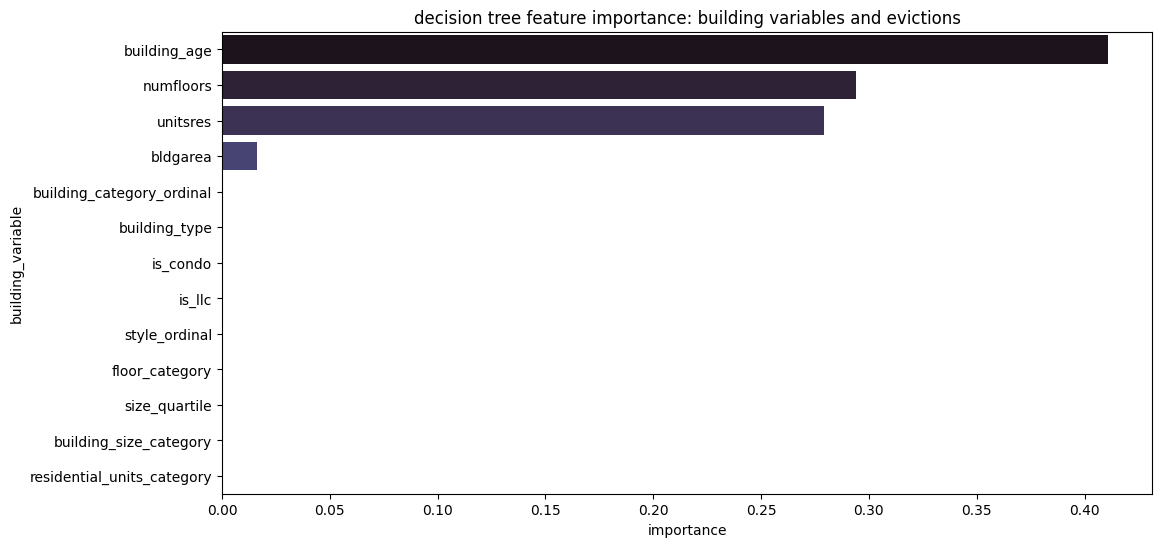

In [ ]:
tree_model = DecisionTreeRegressor(max_depth=4)
tree_model.fit(X, y)
importances = tree_model.feature_importances_

imp_df = pd.DataFrame({'building_variable': new_building_vars, 'importance': importances})
imp_df = imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=imp_df, x='importance', y='building_variable', palette='mako')
plt.title("decision tree feature importance: building variables and evictions")
plt.show()

In [ ]:
# features = [df_building.columns.get_loc('building_age')]
# PartialDependenceDisplay.from_estimator(tree_model, df, features=features)
# plt.title("partial dependence of evictions on building Age")
# plt.show()
# # for some reasons, the age was not a factor to the model at all.

**Very interestingly, here, the building age again poses as the most important factor. This means, the importance score shows how much the feature reduces prediction error (such as mse) across all splits in the tree. Since building_age ranking first, it shows the tree relies most heavily on age to partition the data effectively. Age creates splits that best separate high/low eviction cases.**

## **Part 2.4 RandomForestRegressor analysis.**

In [ ]:
X = df_building[new_building_vars]
y = df_building['average_year_eviction_count']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)
df['predicted_eviction_count'] = model.predict(X)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"mse {mse:.2f}, r square {r2:.2f}")
# much better predictive values than SVI

mse 1.33, r square 0.73


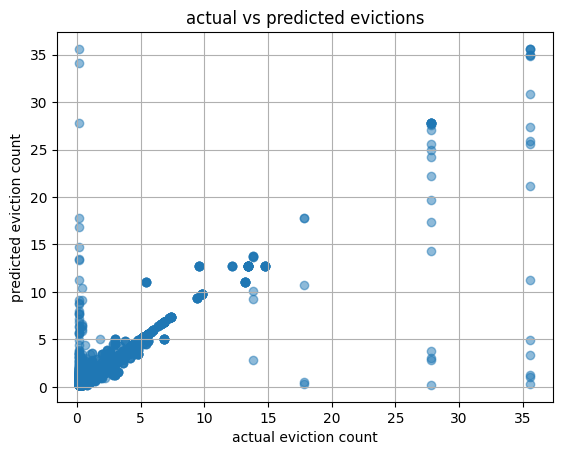

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("actual eviction count")
plt.ylabel("predicted eviction count")
plt.title("actual vs predicted evictions")
plt.grid(True)
plt.show()

**This shows the random forest regressor perform fairly well in predicting eviction counts with the building feature data, based on the trend in the graph and "mse 1.33, r square 0.73" stats results**

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

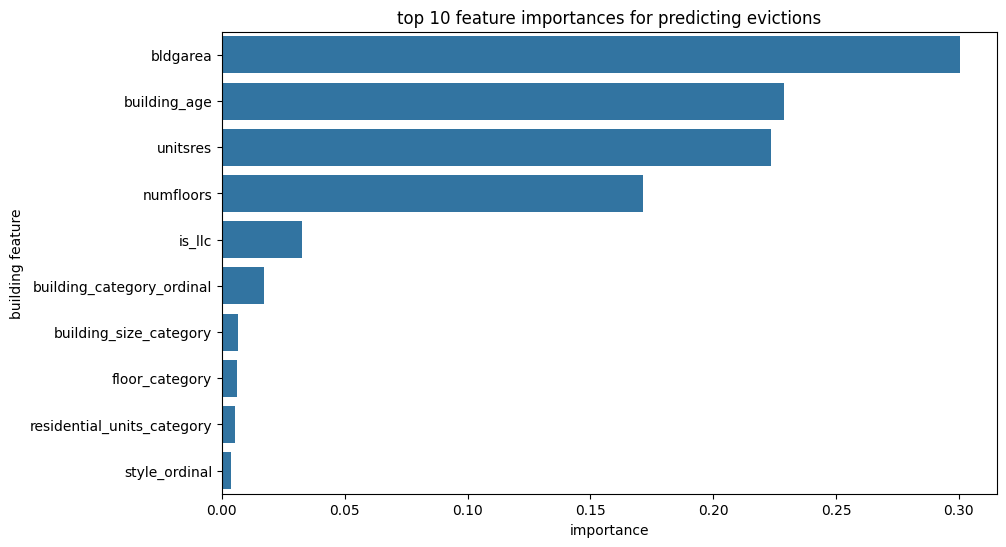

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values[:10], y=feat_importances.index[:10])
plt.title("top 10 feature importances for predicting evictions")
plt.xlabel("importance")
plt.ylabel("building feature")
plt.show()


In [ ]:
top_features_idx = np.argsort(model.feature_importances_)[-3:]
top_features = [new_building_vars[i] for i in top_features_idx]

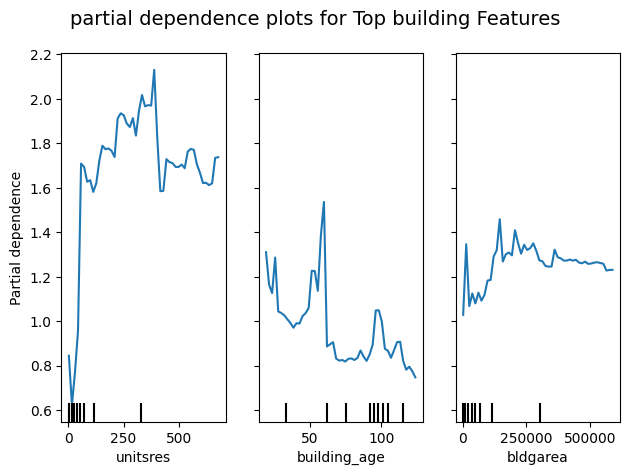

In [ ]:
PartialDependenceDisplay.from_estimator(model, X, top_features, kind='average', grid_resolution=50)
plt.suptitle('partial dependence plots for Top building Features', fontsize=14)
plt.tight_layout()
plt.show()
# good, need to come back to this

**What do these results mean? As the top few factors are different?Spearman correlation missed building age: it only measured the average linear trend (-0.23), hiding the critical mid-age spike (this is actually confirming what we have seen in the bar chart, previously). However, tree models captured it: they split on age thresholds (such as, very young [and therefore usually large buildings] and very old buildings tend to have higher evictions).**

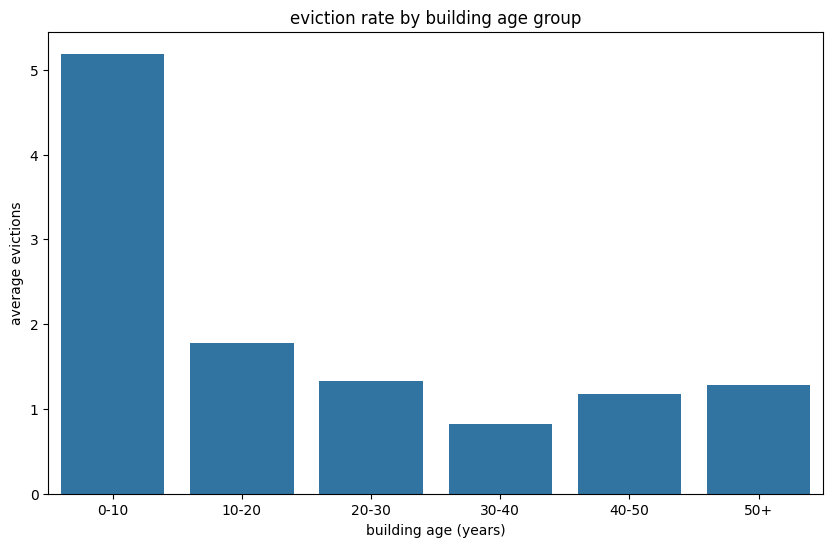

In [ ]:
df_building['age_bin'] = pd.cut(df_building['building_age'],
                       bins=[0, 10, 20, 30, 40, 50, 100],
                       labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50+'])

plt.figure(figsize=(10, 6))
sns.barplot(x='age_bin', y='average_year_eviction_count', data=df_building, ci=None)
plt.title("eviction rate by building age group")
plt.xlabel("building age (years)")
plt.ylabel("average evictions")
plt.show()

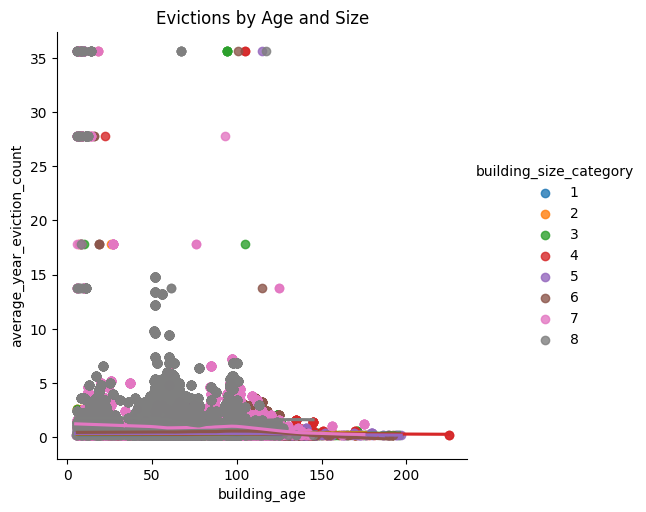

In [ ]:
sns.lmplot(x='building_age', y='average_year_eviction_count',
           hue='building_size_category', data=df_building, lowess=True)
plt.title("evictions by age and size")
plt.show()
# not as clear as expected. needs to come back to this

In [ ]:
# age_bins = df_building.groupby('age_bin').apply(lambda x: x[['building_age', 'average_year_eviction_count']].corr(method='spearman').iloc[0, 1])
# age_bins

<Axes: xlabel='age_group', ylabel='average_year_eviction_count'>

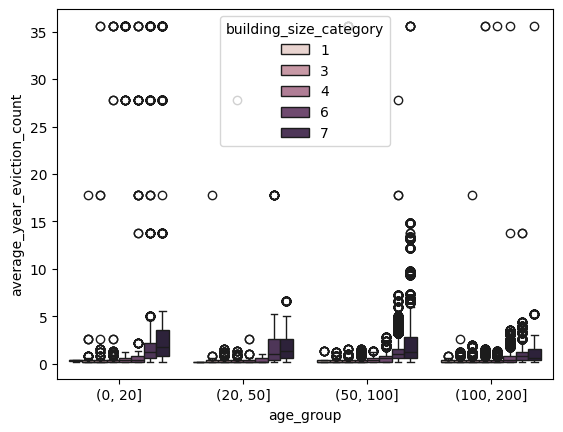

In [ ]:
df_building['age_group'] = pd.cut(df_building['building_age'], bins=[0, 20, 50, 100, 200])
sns.boxplot(x='age_group', y='average_year_eviction_count', hue='building_size_category', data=df_building)
# needs to come back to this

In [ ]:
import statsmodels.api as sm
model = sm.OLS.from_formula('average_year_eviction_count ~ building_age * building_size_category', data=df_building).fit()
print(model.summary())

# not so good results

                                 OLS Regression Results                                
Dep. Variable:     average_year_eviction_count   R-squared:                       0.116
Model:                                     OLS   Adj. R-squared:                  0.115
Method:                          Least Squares   F-statistic:                     2890.
Date:                         Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                                 04:59:09   Log-Likelihood:            -1.4437e+05
No. Observations:                        66397   AIC:                         2.887e+05
Df Residuals:                            66393   BIC:                         2.888e+05
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

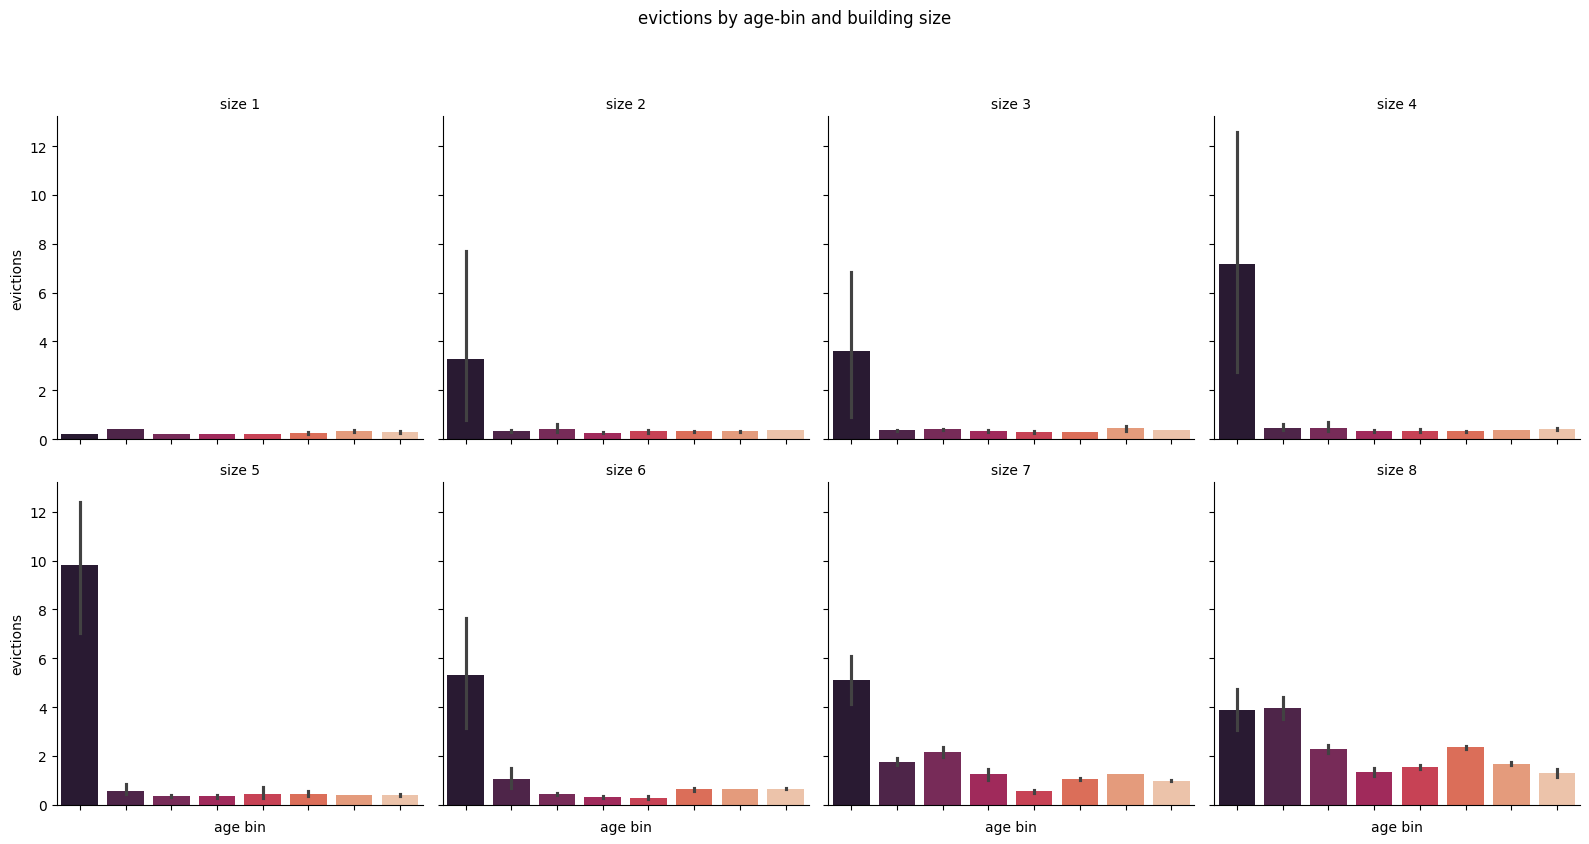

In [ ]:
# cacet grid by size category combining building size and building age
g = sns.FacetGrid(df_building, col='building_size_category', col_wrap=4, height=4)
g.map_dataframe(sns.barplot, x='age_bin', y='average_year_eviction_count', palette='rocket', ci=95)
g.set_titles("size {col_name}")
g.fig.suptitle("evictions by age-bin and building size", y=1.05)
g.set_axis_labels("age bin", "evictions")
[ax.set_xticklabels(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
plt.tight_layout()
# needs to come back to this

### **Evictions cluster in large, old buildings — suggesting structural and institutional risks beyond poverty or tenant complaints. These buildings may be key targets for proactive policy interventions.**

In [ ]:
df_building['is_old_large_building'] = (df_building['age_bin'] == 'Pre-War') & (df_building['building_size_category'].isin([5,6,7,8]))

In [ ]:
df_building['age_size_interaction'] = df_building['building_size_category'] * df_building['age_bin'].cat.codes

In [ ]:
# df_building['is_old_large_building'].mean()
# # % of buildings that fall into this category
# df_building.groupby('is_old_large_building')['average_year_eviction_count'].mean()

In [ ]:
# sns.boxplot(data=df_building, x='is_old_large_building', y='average_year_eviction_count')
# plt.title("eviction rate by old large building status")